## **Исследование надёжности банковских заёмщиков**

*Проект для проработки навыка предварительной обработки данных.*

Заказчик — кредитный отдел банка. Нужно понять, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — системы, оценивающей способность потенциального заёмщика вернуть кредит банку.

**Описание данных**
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита
     

### **1. Предварительный анализ входных данных**


In [1]:
import pandas as pd

In [2]:
bank_stat = pd.read_csv('data.csv')
bank_stat.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [3]:
bank_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### **Вывод**

Данные нуждаются в предобработке:

1) Столбцы days_employed и total_income имеют пропущенные значения.

2) Столбец days_employed и столбец total_income имеют тип float64, что может быть было сделано специально, но такая точность в данном случае только мешает восприятию информации - поэтому было бы лучше заменить их на целочисленное значение.

3) Столбец days_employed имеет отрицательные значения (этот столбец показывает общий трудовой стаж в днях). Предполагаю, что это или ошибка ввода или отрицательные значения показывают, что человек сейчас без работы, но при этом в дееспособном возрасте.

4) Есть столбцы с одинаковыми значениями, но записанными в разном регистре (например, в столбце education) - это может мешать дальнейшей группировке данных.


### **2. Предобработка данных**

### **Обработка пропусков**

Обработаем столбцы с пропущенными данными: days_employed и total_income.

Столбец days_employed:

In [4]:
print(bank_stat.loc[bank_stat['days_employed']>0].shape[0])

3445


In [5]:
print(bank_stat['days_employed'].loc[bank_stat['days_employed']<0].count())

15906


In [6]:
bank_stat['days_employed'].isna().sum()

2174

Пропусков в целом вполне допустимое количество (около 10%), а вот отрицательных значений подозрительно много, не похоже на простую опечатку. Предполагаю, что минус мог появится, например, в результате переноса данных из одной системы в другую (поэтому количество отрицательных значений такое большое), и нужно избавится от этого минуса, тк общий трудовой стаж не может быть отрицательным. 

Также в столбце втречаются очень большие числа, поэтому переведу все данные этого столбца в года для проверки значений на адекватность.

In [7]:
bank_stat['days_employed_in_years'] = bank_stat['days_employed']/365 

In [8]:
bank_stat['days_employed_in_years'].hist()

<AxesSubplot:>

Данные выглядят неадекватно - трудовой стаж не может составлять 900-1100 лет.

Посмотрим поближе:

<AxesSubplot:>

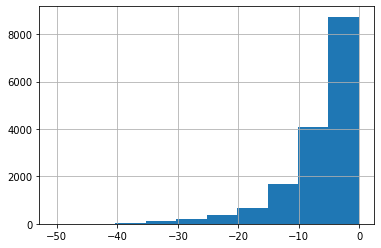

In [9]:
bank_stat['days_employed_in_years'].loc[bank_stat['days_employed_in_years']<100].hist()

<AxesSubplot:>

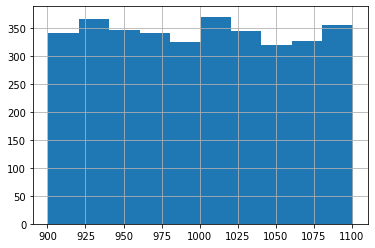

In [10]:
bank_stat['days_employed_in_years'].loc[bank_stat['days_employed_in_years']>800].hist()

Предполагаю, что данные, которые ушли в минус - это и есть "адекватные" данные для работы, которые при переносе или каком-то еще процессе по ошибке стали отрицательными. Остальные же данные кажутся просто случайно проставленными большими числами.

Если посмотреть на таблицу и попробовать понять с какими еще параметрами может связан такой большой трудовой стаж, то в глаза бросаются пенсионеры, поэтому посмотрим на них поближе:

In [11]:
bank_stat['days_employed_in_years'].loc[bank_stat['income_type'] == 'пенсионер'].describe()

count    3443.000000
mean     1000.009565
std        57.724948
min       900.626632
25%       949.724236
50%      1000.584401
75%      1049.949033
max      1100.699727
Name: days_employed_in_years, dtype: float64

In [12]:
bank_stat['days_employed_in_years'].loc[bank_stat['income_type'] == 'сотрудник'].describe()

count    10014.000000
mean        -6.373970
std          6.323080
min        -50.380685
25%         -8.515406
50%         -4.312884
75%         -2.043911
max         -0.066141
Name: days_employed_in_years, dtype: float64

Действительно, у категории "пенсионер" среднее число лет работы - 1000, а у категории "сотрудник", например - 6 лет, что уже похоже на адекватные данные (при замене чисел на положительные).

Построю сводную таблицу для всех типов занятости:

In [13]:
bank_stat.groupby('income_type')['days_employed_in_years'].describe()

,count,mean,std,min,25%,50%,75%,max
income_type,,,,,,,,
безработный,2.0,1003.873021,111.932818,924.724567,964.298794,1003.873021,1043.447248,1083.021476
в декрете,1.0,-9.032219,NaN,-9.032219,-9.032219,-9.032219,-9.032219,-9.032219
госслужащий,1312.0,-9.314786,7.639374,-41.624746,-13.039450,-7.368132,-3.444306,-0.109463
компаньон,4577.0,-5.784998,5.612188,-48.261817,-7.881229,-4.239403,-1.878596,-0.082727
пенсионер,3443.0,1000.009565,57.724948,900.626632,949.724236,1000.584401,1049.949033,1100.699727
предприниматель,1.0,-1.426981,NaN,-1.426981,-1.426981,-1.426981,-1.426981,-1.426981
сотрудник,10014.0,-6.373970,6.323080,-50.380685,-8.515406,-4.312884,-2.043911,-0.066141
студент,1.0,-1.585621,NaN,-1.585621,-1.585621,-1.585621,-1.585621,-1.585621


Невооруженным глазом видно, что по среднему кол-ву лет (и по минимальному числу лет также) выделяются два типа: "безработный" и "пенсионер". Безработных можно не расматривать, тк их в данной выборке всего 2 человека, а вот пенсионеров внушительная часть.

Заменю все отрицательные значения на положительные.

In [14]:
bank_stat['days_employed_in_years'] = bank_stat['days_employed_in_years'].abs()

Чтобы избежать скачков в результатах - заменим все неадекватные значения в трудовом стаже пенсионеров на что-то среднее:
с 18 до 60 лет максимум можно проработать 42 года. Но учитывая то, что пенсионеры бывают разные и кто-то перестает работать раньше, а кто-то еще работает после выхода на пенсию, возьмем что-то ближе к максимуму этого значения (тк раньше это было 900 лет - сильно статистику это не должно испортить) - возьмем 37 лет, например.
Заменим у всех пенсионеров, у которых трудовой стаж больше 100 лет стаж на 37 лет.

In [15]:
bank_stat.loc[(bank_stat['income_type'] == 'пенсионер') & (bank_stat['days_employed_in_years'] > 100), 'days_employed_in_years'] = 37
bank_stat.loc[bank_stat['income_type'] == 'пенсионер']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_in_years
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,37.0
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу,NaN
18,0,400281.136913,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля,37.0
24,1,338551.952911,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью,37.0
25,0,363548.489348,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21505,0,338904.866406,53,среднее,1,гражданский брак,1,M,пенсионер,0,75439.993167,сыграть свадьбу,37.0
21508,0,386497.714078,62,среднее,1,женат / замужем,0,M,пенсионер,0,72638.590915,недвижимость,37.0
21509,0,362161.054124,59,высшее,0,женат / замужем,0,M,пенсионер,0,73029.059379,операции с недвижимостью,37.0
21518,0,373995.710838,59,СРЕДНЕЕ,1,женат / замужем,0,F,пенсионер,0,153864.650328,сделка с автомобилем,37.0


Вернемся к пропускам в столбце days_employed_in_years. Попробую еще найти причину пропусков (может быть она тоже связана с типом занятости, например).

In [16]:
bank_stat.loc[bank_stat['days_employed'].isna()].groupby('income_type').describe()

children                                                \
                   count      mean       std  min  25%  50%  75%   max   
income_type                                                              
госслужащий        147.0  0.687075  1.797269  0.0  0.0  0.0  1.0  20.0   
компаньон          508.0  0.614173  1.666693 -1.0  0.0  0.0  1.0  20.0   
пенсионер          413.0  0.164649  1.414903 -1.0  0.0  0.0  0.0  20.0   
предприниматель      1.0  0.000000       NaN  0.0  0.0  0.0  0.0   0.0   
сотрудник         1105.0  0.651584  1.314930 -1.0  0.0  0.0  1.0  20.0   

                days_employed       ... total_income      \
                        count mean  ...          75% max   
income_type                         ...                    
госслужащий               0.0  NaN  ...          NaN NaN   
компаньон                 0.0  NaN  ...          NaN NaN   
пенсионер                 0.0  NaN  ...          NaN NaN   
предприниматель           0.0  NaN  ...          NaN NaN   
сотрудник                 0.0  NaN  ...          NaN NaN   

                days_employed_in_years                               
                                 count mean std min 25% 50% 75% max  
income_type                                                          
госслужащий                        0.0  NaN NaN NaN NaN NaN NaN NaN  
компаньон                          0.0  NaN NaN NaN NaN NaN NaN NaN  
пенсионер                          0.0  NaN NaN NaN NaN NaN NaN NaN  
предприниматель                    0.0  NaN NaN NaN NaN NaN NaN NaN  
сотрудник                          0.0  NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 64 columns]

Предположение, что пропуски как-то связаны с типом занятости не оправдалось - пропуски раскиданы по разным типам и предполагаю, что могли появится просто от того, что у клиента не было с собой трудовой книжки или он решил не раскрывать данные о своем трудовом стаже.

Заменим пропуски. Чтобы не помешать анализу данных из этой таблицы, можно, например, разделить данные по возрасту на 4-5 категорий, найти медианное значение по каждой из категорий, и заполнить им все пропущенные значения в каждой из категорий.

Для начала посмотрим сколько в столбце возраста нулей:

In [17]:
print(bank_stat.loc[bank_stat['dob_years'] == 0].shape[0])

101


Теперь посмотрим какие там вообще бывают значения (в том числе, чтобы посмотреть минимум и максимум). 

In [18]:
sorted(bank_stat['dob_years'].unique())

[0,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75]

<AxesSubplot:>

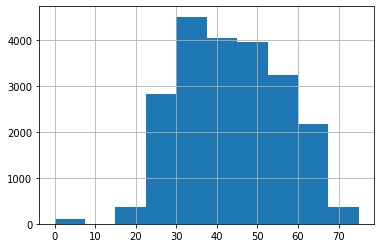

In [19]:
bank_stat['dob_years'].hist()

<AxesSubplot:xlabel='dob_years', ylabel='days_employed_in_years'>

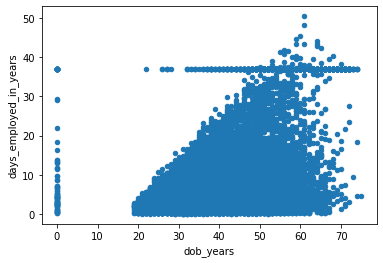

In [20]:
bank_stat[bank_stat['days_employed_in_years']<100].plot.scatter('dob_years', 'days_employed_in_years')

Исходя из этих таблиц, я бы разделила столбец возраста на такие подкатегории: 18-23, 23-30, 30-38, 38-53, 53-75.

In [21]:
bank_stat['dob_years_category']  = pd.cut(bank_stat['dob_years'], [18,23,30,38,53,75]) 

Построим сводную таблицу:

In [22]:
bank_stat.groupby('dob_years_category')['days_employed_in_years'].agg(('count', 'mean', 'median'))

,count,mean,median
dob_years_category,,,
"(18, 23]",536,2.190293,1.879721
"(23, 30]",2830,3.838018,3.161246
"(30, 38]",4105,5.942103,4.355565
"(38, 53]",7063,9.749336,6.228653
"(53, 75]",4726,26.571325,37.000000


Здесь нужно помнить о том, что всем пенсионерам, у которых был неадекватный трудовой стаж, мы поставили стаж 37 лет.



Найдем все пропущенные в найденных подкатегориях значения и заполним их медианами трудового стажа для этой подкатегории.

In [23]:
for t in bank_stat['dob_years_category'].unique():
    print(t)
    curr = bank_stat.loc[bank_stat['dob_years_category'] == t]
    curr_median = curr['days_employed_in_years'].median()
    print(curr.loc[curr['days_employed_in_years'].isna()].shape[0])
    bank_stat.loc[bank_stat['dob_years_category'] == t, 'days_employed_in_years'] = curr['days_employed_in_years'].fillna(value = curr_median)
    
bank_stat['days_employed_in_years'].isna().sum()

(38.0, 53.0]
786
(30.0, 38.0]
456
(23.0, 30.0]
280
(53.0, 75.0]
565
(18.0, 23.0]
77
nan
0


10

После замены, у нас осталось 10 строк, где возраст равен нулю, а также есть пропуск в стаже работы. Найдем и избавимся от них (на данные это не повлияет, тк это всего 10 строк).

In [24]:
bank_stat.loc[(bank_stat['days_employed_in_years'].isna())].index

Int64Index([1890, 2284, 4064, 5014, 6411, 6670, 8574, 12403, 13741, 19829], dtype='int64')

In [25]:
bank_stat = bank_stat.drop(bank_stat.loc[(bank_stat['days_employed_in_years'].isna())].index)

In [26]:
bank_stat.loc[(bank_stat['days_employed_in_years'].isna())].count()

children                  0
days_employed             0
dob_years                 0
education                 0
education_id              0
family_status             0
family_status_id          0
gender                    0
income_type               0
debt                      0
total_income              0
purpose                   0
days_employed_in_years    0
dob_years_category        0
dtype: int64

С первым столбцом разобрались, перехожу ко второму - total_income.

In [27]:
bank_stat['total_income'].isna().sum()

2164

Интересно, что в столбце с типом занятости пропущенно столько же значений, сколько и в столбце с трудовым стажем.

Посмотрим не одни ли и те же это значения.

In [28]:
bank_stat.loc[(bank_stat['days_employed'].isna()) & (bank_stat['total_income'].isna())].groupby('income_type').describe()

children                                                \
                   count      mean       std  min  25%  50%  75%   max   
income_type                                                              
госслужащий        147.0  0.687075  1.797269  0.0  0.0  0.0  1.0  20.0   
компаньон          506.0  0.614625  1.669678 -1.0  0.0  0.0  1.0  20.0   
пенсионер          410.0  0.165854  1.420012 -1.0  0.0  0.0  0.0  20.0   
предприниматель      1.0  0.000000       NaN  0.0  0.0  0.0  0.0   0.0   
сотрудник         1100.0  0.651818  1.315425 -1.0  0.0  0.0  1.0  20.0   

                days_employed       ... total_income      \
                        count mean  ...          75% max   
income_type                         ...                    
госслужащий               0.0  NaN  ...          NaN NaN   
компаньон                 0.0  NaN  ...          NaN NaN   
пенсионер                 0.0  NaN  ...          NaN NaN   
предприниматель           0.0  NaN  ...          NaN NaN   
сотрудник                 0.0  NaN  ...          NaN NaN   

                days_employed_in_years                                   \
                                 count       mean        std        min   
income_type                                                               
госслужащий                      147.0   9.789719  11.516544   1.879721   
компаньон                        506.0   8.784552  10.532306   1.879721   
пенсионер                        410.0  32.321016  11.101172   3.161246   
предприниматель                    1.0  37.000000        NaN  37.000000   
сотрудник                       1100.0   8.767325  10.559850   1.879721   

                                                        
                       25%        50%        75%   max  
income_type                                             
госслужащий       4.355565   6.228653   6.228653  37.0  
компаньон         4.355565   6.228653   6.228653  37.0  
пенсионер        37.000000  37.000000  37.000000  37.0  
предприниматель  37.000000  37.000000  37.000000  37.0  
сотрудник         4.355565   6.228653   6.228653  37.0  

[5 rows x 64 columns]

Получаем точно такую же таблицу, а значит люди, которые предпочли не указывать свою заработную плату (ежемесячный доход) также предпочли не указывать и свой тип занятости.

In [29]:
bank_stat.groupby('income_type')['total_income'].describe()

,count,mean,std,min,25%,50%,75%,max
income_type,,,,,,,,
безработный,2.0,131339.751676,100950.466876,59956.991984,95648.371830,131339.751676,167031.131522,2.027225e+05
в декрете,1.0,53829.130729,NaN,53829.130729,53829.130729,53829.130729,53829.130729,5.382913e+04
госслужащий,1312.0,170898.309923,96878.763554,29200.077193,105294.668418,150447.935283,209173.052434,9.104515e+05
компаньон,4577.0,202417.461462,130481.095793,28702.812889,125887.745820,172357.950966,243907.839199,2.265604e+06
пенсионер,3443.0,137127.465690,80246.953231,20667.263793,82881.443465,118514.486412,169700.433010,7.351033e+05
предприниматель,1.0,499163.144947,NaN,499163.144947,499163.144947,499163.144947,499163.144947,4.991631e+05
сотрудник,10014.0,161380.260488,91322.514795,21367.648356,102795.633631,142594.396847,196828.082600,1.726276e+06
студент,1.0,98201.625314,NaN,98201.625314,98201.625314,98201.625314,98201.625314,9.820163e+04


Пропуски здесь - это те же 10% всех данных, но на этот раз их логичнее будет заменить медианой дохода по категории занятости (тк доход чаще всего связан с занимаемой должностью).

In [30]:
for t in bank_stat['income_type'].unique():
    print(t)
    curr = bank_stat.loc[bank_stat['income_type'] == t]
    curr_median = curr['total_income'].median()
    print(curr.loc[curr['total_income'].isna()].shape[0])
    bank_stat.loc[bank_stat['income_type'] == t, 'total_income'] = curr['total_income'].fillna(value = curr_median)
    
bank_stat['total_income'].isna().sum()

сотрудник
1100
пенсионер
410
компаньон
506
госслужащий
147
безработный
0
предприниматель
1
студент
0
в декрете
0


0

### **Вывод**

Были удалены пропуски в столбце days_employed_in_years (days_employed в годах) и в столбце total_income, а также были предобработанны данные в столбце days_employed_in_years (отрицательные значения были заменены положительными и слишком большие значения были заменены на медианные значения по категориям).
Пропуски в двух столбцах были связаны (то есть находились в одних и тех же строчках), так что можно предположить, что люди, которые не хотят рассказывать о своем заработке, также не хотят говорить о своем трудовом стаже.

### **3. Замена типа данных**

In [31]:
bank_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21515 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   children                21515 non-null  int64   
 1   days_employed           19351 non-null  float64 
 2   dob_years               21515 non-null  int64   
 3   education               21515 non-null  object  
 4   education_id            21515 non-null  int64   
 5   family_status           21515 non-null  object  
 6   family_status_id        21515 non-null  int64   
 7   gender                  21515 non-null  object  
 8   income_type             21515 non-null  object  
 9   debt                    21515 non-null  int64   
 10  total_income            21515 non-null  float64 
 11  purpose                 21515 non-null  object  
 12  days_employed_in_years  21515 non-null  float64 
 13  dob_years_category      21424 non-null  category
dtypes: category(1), float6

Столбец days_employed и столбец total_income имеют тип float64, но такая точность в данном случае только мешает восприятию информации - лучше заменить их на int64 (целочисленное значение).

In [32]:
bank_stat['days_employed_in_years'] = bank_stat['days_employed_in_years'].astype('int64')

In [33]:
bank_stat['total_income'] = bank_stat['total_income'].astype('int64')

In [34]:
bank_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21515 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   children                21515 non-null  int64   
 1   days_employed           19351 non-null  float64 
 2   dob_years               21515 non-null  int64   
 3   education               21515 non-null  object  
 4   education_id            21515 non-null  int64   
 5   family_status           21515 non-null  object  
 6   family_status_id        21515 non-null  int64   
 7   gender                  21515 non-null  object  
 8   income_type             21515 non-null  object  
 9   debt                    21515 non-null  int64   
 10  total_income            21515 non-null  int64   
 11  purpose                 21515 non-null  object  
 12  days_employed_in_years  21515 non-null  int64   
 13  dob_years_category      21424 non-null  category
dtypes: category(1), float6

### **Вывод**

Данные в столбцах days_employed и столбец total_income были заменены на целочисленные.

### **4. Обработка дубликатов**

Чтобы посмотреть есть ли в таблице дубликаты - нужно привести все строки к нижнему регистру.

In [35]:
bank_stat['education'].value_counts()

среднее                13743
высшее                  4716
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   267
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Проверили уникальные значения в столбце образования - здесь нашлось много одинаковых значений в разном регистре.

Исправим это:

In [36]:
bank_stat['education'] = bank_stat['education'].str.lower()
bank_stat['education'].value_counts()

среднее                15226
высшее                  5257
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Теперь проверим также все остальные строковые столбцы: family_status, gender, income_type и purpose.

In [37]:
bank_stat['family_status'].value_counts()

женат / замужем          12376
гражданский брак          4174
Не женат / не замужем     2812
в разводе                 1194
вдовец / вдова             959
Name: family_status, dtype: int64

В столбце family_status все в порядке.

In [38]:
bank_stat['gender'].value_counts()

F      14228
M       7286
XNA        1
Name: gender, dtype: int64

В столбце gender нашлось необычное значение XNA, но тк оно одно - можно его не обрабтывать, на общую выборку оно не повлияет.

In [39]:
bank_stat['income_type'].value_counts()

сотрудник          11114
компаньон           5083
пенсионер           3853
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

В столбце income_type тоже все в порядке.

In [40]:
purpose_unique_values = bank_stat['purpose'].unique()
purpose_unique_values

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

В столбце purpose очень много одинаковых по сути причин взятия кредита, но написанных разными словами, с ним можно дальше поработать с помощью лемматизации.

Вернемся к задаче удаления дубликатов. Для начала посчитаем их количество.

In [41]:
bank_stat.duplicated().sum()

71

Удалим все найденные дубликаты:

In [42]:
bank_stat = bank_stat.drop_duplicates()

Проверим, что дубликатов не осталось:

In [43]:
bank_stat.duplicated().sum()

0

### **Вывод**
Слова в строковых столбцах были приведены к нижнему регистру, а также были удалены дубликаты.

### **5. Лемматизация**

Как было выяснено выше, нужно лемматизировать столбец purpose, чтобы привести цели кредита к единым категориям.
Используем .lemmatize() для приведения слов к их словарным формам.

In [44]:
from pymystem3 import Mystem
m = Mystem()
all_lemmas = []
for lemma in purpose_unique_values:
    lemmas = m.lemmatize(lemma)
    all_lemmas += lemmas
    print(lemmas)

['покупка', ' ', 'жилье', '\n']
['приобретение', ' ', 'автомобиль', '\n']
['дополнительный', ' ', 'образование', '\n']
['сыграть', ' ', 'свадьба', '\n']
['операция', ' ', 'с', ' ', 'жилье', '\n']
['образование', '\n']
['на', ' ', 'проведение', ' ', 'свадьба', '\n']
['покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', '\n']
['покупка', ' ', 'недвижимость', '\n']
['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n']
['строительство', ' ', 'собственный', ' ', 'недвижимость', '\n']
['недвижимость', '\n']
['строительство', ' ', 'недвижимость', '\n']
['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n']
['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n']
['операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['строительство', ' ', 'жилой', ' ', 'недвижимость', '\n']
['жилье', '\n']
['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '\n']
['автомобиль', '\n']
['заниматься', ' ', 'образование'

### **Вывод**

Была произведена лемматизация столбца purpose используя lemmatize, теперь у нас есть список слов в их изначальных словоформах, которые уже будет легче категоризовать.

### **6. Категоризация данных**

Используем Counter для подсчета наиболее встречающихся слов:

In [45]:
from collections import Counter
print(Counter(all_lemmas))

Counter({' ': 59, '\n': 38, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'подержать': 1, 'со': 1, 'подержанный': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1})


Из списка выпишем все цели: недвижимость, автомобиль, образование, жилье, свадьба (можно было бы еще выделить "строительство", но если посмотреть на изначальные формы - то это обычно строительство жилья, а жилье у нас уже есть).

Приведем все строки к выбранным выше категориям с помощью функции.

In [46]:
def categorize_purpose(row):
    data = m.lemmatize(row)
    if 'жилье' in data:
        return 'недвижимость'
    if 'автомобиль' in data:
        return 'автомобиль'
    if 'образование' in data:
        return 'образование'
    if 'недвижимость' in data:
        return 'недвижимость'
    if 'свадьба' in data:
        return 'свадьба'
    return data 

bank_stat['clean_purpose'] = bank_stat['purpose'].map(categorize_purpose)
bank_stat['clean_purpose'].value_counts()

недвижимость    10803
автомобиль       4306
образование      4013
свадьба          2322
Name: clean_purpose, dtype: int64

### **Вывод**

Теперь с данными в столбце purpose удобно работать - они все приведены к 4ем категориям. 

**Данные в таблице была предобработаны для анализа и можно еще раз посмотреть на изначальную задачу: Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.**

### **7. Находим зависимости возврата кредита**

**7.1 Есть ли зависимость между наличием детей и возвратом кредита в срок?**

Построим сводную таблицу зависимости детей и выплаты кредита в срок, посчитаем количество выплаченных и не выплаченных вовремя кредитов (если в столбце debt стоит 1 - есть задержка выплаты кредита).

In [47]:
children_debt = bank_stat.pivot_table(index=['children'], columns=['debt'], values='education', aggfunc='count')
display(children_debt)

debt,0,1
children,,
-1,46.0,1.0
0,13020.0,1063.0
1,4363.0,444.0
2,1858.0,194.0
3,302.0,27.0
4,37.0,4.0
5,9.0,NaN
20,68.0,8.0


Сомнение вызывает наличие "-1" ребенка.
Предположим, это просто ошибка ручного ввода - таких строк не так много по сравнению с основным кол-вом данных.

Исправлю данные:

In [48]:
bank_stat['children'] = bank_stat['children'].abs()

Посмотрим на сводную таблицу еще раз:

In [49]:
children_debt = bank_stat.pivot_table(index=['children'], columns=['debt'], values='education', aggfunc='count')
display(children_debt)

debt,0,1
children,,
0,13020.0,1063.0
1,4409.0,445.0
2,1858.0,194.0
3,302.0,27.0
4,37.0,4.0
5,9.0,NaN
20,68.0,8.0


Наличие 20 детей кажется немного сомнительным в современном мире (и то, что ни у кого нет варианта 18 детей, у всех после 5 - сразу 20), я бы предположила, что это писали 2, и случано добавили ноль, но на раскладке клавиатуры они находятся далеко друг от друга, так что оставлю все как есть (может быть, например, в системе при заполнении кол-ва детей было поле со скролингом и 20 - это просто был максимум, который иногда случайно ставили вместо какого угодно другого количества детей).

Для того, чтобы сказать о зависимости  - нужно найти процентное соотношение числа невыплативших кредит вовремя к общему числу людей с таким количеством детей. Найдем это процентное соотношение.

In [50]:
children_debt[1] / (children_debt[0]+children_debt[1]) *100

children
0      7.548108
1      9.167697
2      9.454191
3      8.206687
4      9.756098
5           NaN
20    10.526316
dtype: float64

### **Вывод**

Исходя из полученных процентных соотношений получается, что процент невыплачиваемости кредита в срок немного ниже (всего на 1,5%) у людей, у которых нет детей совсем (то есть им выдавать кредит предпочтительнее при прочих равных), а если дети есть - то не так уже важно сколько их, процент невыплачиваемости будет не очень сильно разнится (от 8.2 до 9.7 процентов). 
В таблице видно, что люди, у которых 5 детей - все выплатили кредит в срок, но на деле их и выплативших всего 9 человек, поэтому ориентироваться на эти данные нельзя.

**7.2 Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Построим сводную таблицу зависимости семейного положения и выплаты кредита в срок, посчитаем количество выплаченных и не выплаченных вовремя кредитов.

In [51]:
family_status_debt = bank_stat.pivot_table(index=['family_status'], columns=['debt'], values='education', aggfunc='count')
display(family_status_debt)

debt,0,1
family_status,,
Не женат / не замужем,2535,274
в разводе,1109,85
вдовец / вдова,895,63
гражданский брак,3760,388
женат / замужем,11404,931


Теперь снова посмотрим на процентное соотношение.

In [52]:
family_status_debt[1] / (family_status_debt[0] + family_status_debt[1]) *100

family_status
Не женат / не замужем    9.754361
в разводе                7.118928
вдовец / вдова           6.576200
гражданский брак         9.353905
женат / замужем          7.547629
dtype: float64

### **Вывод**

Из полученных данных можно сделать вывод, что люди, которые женаты/замужем, в разводе или которые оказались вдовой/вдовцом чаще отдают кредит в срок, чем тем, кто живет в гражданском браке или не женат/не замужем.

Из этих данных можно предположить, что чем старше человек - тем больше вероятность, что он отдаст кредит в срок, что тоже можно проверить.

In [53]:
dob_years_category_debt = bank_stat.pivot_table(index=['dob_years_category'], columns=['debt'], values='education', aggfunc='count')
display(dob_years_category_debt)

debt,0,1
dob_years_category,,
"(18, 23]",547,64
"(23, 30]",2767,339
"(30, 38]",4099,454
"(38, 53]",7246,582
"(53, 75]",4961,294


In [54]:
dob_years_category_debt[1] / (dob_years_category_debt[0] + dob_years_category_debt[1]) *100

dob_years_category
(18, 23]    10.474632
(23, 30]    10.914359
(30, 38]     9.971447
(38, 53]     7.434849
(53, 75]     5.594672
dtype: float64

Да, мы подтвердили, что чем старше люди - тем больше вероятность, что они выплатят кредит в срок.

**7.3 Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Посмотрим какие вообще уровни дохода есть в столбце total_income.

<AxesSubplot:>

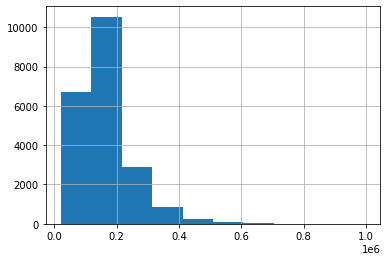

In [55]:
bank_stat['total_income'].loc[bank_stat['total_income']<1000000].hist()

<AxesSubplot:xlabel='total_income', ylabel='debt'>

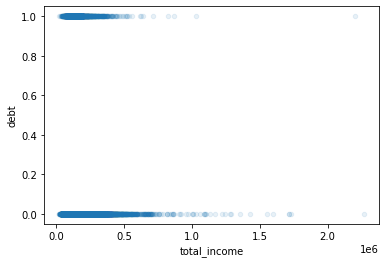

In [56]:
bank_stat.plot.scatter('total_income', 'debt', alpha = 0.1)

Но из второго графика видно, что в разных уровнях дохода не равное кол-во людей, поэтому разделим их на 5 равных категорий с помощью qcut (которая в каждой категории оставит одинаковое кол-во людей).

In [57]:
bank_stat['total_income_category'] = pd.qcut(bank_stat['total_income'], 5)
bank_stat.groupby('total_income_category').count()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_in_years,dob_years_category,clean_purpose
total_income_category,,,,,,,,,,,,,,,
"(20666.999, 98528.8]",4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4266,4289
"(98528.8, 132125.0]",4289,3906,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4270,4289
"(132125.0, 161376.2]",4288,3078,4288,4288,4288,4288,4288,4288,4288,4288,4288,4288,4288,4279,4288
"(161376.2, 214682.8]",4289,3790,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4272,4289
"(214682.8, 2265604.0]",4289,4288,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4289,4266,4289


Теперь уже в каждой категории посмотрим кол-во невозвратов.

In [58]:
total_income_debt = bank_stat.pivot_table(index=['total_income_category'], columns=['debt'], values='education', aggfunc='count')
display(total_income_debt)

debt,0,1
total_income_category,,
"(20666.999, 98528.8]",3945,344
"(98528.8, 132125.0]",3928,361
"(132125.0, 161376.2]",3913,375
"(161376.2, 214682.8]",3928,361
"(214682.8, 2265604.0]",3989,300


И найдем процентное соотношение невозвратов к общему кол-ву людей в категории (которое у нас равное).

In [59]:
total_income_debt[1] / (total_income_debt[0] + total_income_debt[1]) *100

total_income_category
(20666.999, 98528.8]     8.020518
(98528.8, 132125.0]      8.416880
(132125.0, 161376.2]     8.745336
(161376.2, 214682.8]     8.416880
(214682.8, 2265604.0]    6.994637
dtype: float64

### **Вывод**

Из полученной таблицы видно, что чаще всего возвращают кредит в срок люди, у которых уровень дохода выше 214 единиц.

**7.4 Как разные цели кредита влияют на его возврат в срок?**

In [60]:
bank_stat.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose', 'days_employed_in_years',
       'dob_years_category', 'clean_purpose', 'total_income_category'],
      dtype='object')

Выше с помощью лемматизации я уже привела данные о целях кредита к единым категориям, так что теперь можно построить сводную таблицу зависимости целей кредита и выплаты кредита в срок, используя колонку clean_purpose.

In [61]:
purpose_debt = bank_stat.pivot_table(index=['clean_purpose'], columns=['debt'], values='education', aggfunc='count')
display(purpose_debt)

debt,0,1
clean_purpose,,
автомобиль,3903,403
недвижимость,10021,782
образование,3643,370
свадьба,2136,186


Найдем процентное соотношение:

In [62]:
purpose_debt_2 = bank_stat.pivot_table(index=['clean_purpose'], values='debt', aggfunc=['sum', 'count', 'mean'])
display(purpose_debt_2)

,sum,count,mean
,debt,debt,debt
clean_purpose,,,
автомобиль,403,4306,0.093590
недвижимость,782,10803,0.072387
образование,370,4013,0.092200
свадьба,186,2322,0.080103


In [63]:
purpose_debt[1] / (purpose_debt[0] + purpose_debt[1]) *100

clean_purpose
автомобиль      9.359034
недвижимость    7.238730
образование     9.220035
свадьба         8.010336
dtype: float64

### **Вывод**

Из полученных данных видно, что люди, берущие кредит на недвижимость, выплачивают его в срок чаще, чем те кто берет его на свадьбу, а те, кто берут его на свадьбу - выплачивают кредит вовремя чаще, чем те, кто берет кредит на образование или автомобиль.

## **Общий вывод**

1. **Данные были предобработаны:**

1) Удалены пропуски

2) Часть значений заменена из-за наличия ошибок (слишком большие или отрицательные значения)

3) Исправлен тип данных в нескольких столбцах

4) Обработаны дубликаты (данные приведены к общему виду с помощью замены регистра, лемматизации и категоризации данных).

2. **Анализ взаимосвязей данных показал, что:**

1) Процент возврата кредита в срок выше у людей не имеющих детей.

2) Люди, у которых семейное положение "Женат/замужем", "В разводе" или которые оказались вдовой/вдовцом - чаще отдают кредит в срок, чем те, кто живет в гражданском браке или холосты.

3) Люди, у которых уровень дохода выше 214 единиц, чаще других возвращают кредит в срок.

4) Люди, берущие кредит на недвижимость, выплачивают его в срок чаще, чем те кто берет его на свадьбу, а те, кто берут его на свадьбу - выплачивают кредит вовремя чаще, чем те, кто берет кредит на образование или автомобиль.

То есть все 4 рассмотренных в работе фактора влияют на возврат долга в банке, и их стоит учитывать в модели кредитного скоринга.



